## Using *complexity_entropy()*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
np.random.seed(1)

### Dataset

In [2]:
from src.series import skew_tent_map, logistic_map, henon_map, schuster_map, henon_map, lorenz_map

In [3]:
sine_data = np.sin(np.arange(0, 10000, .01))
gaussian_noise = np.random.normal(size=100000)

In [4]:
from statsmodels.tsa.arima_process import arma_generate_sample
ar = np.array([1, 0.75, -0.25])
ma = np.array([1, 0.65, 0.35])
arma_process = arma_generate_sample(ar, ma, 10000)

In [5]:
import yfinance as yf
snp = yf.download("^GSPC", start='1993-02-01', end='2023-12-17')
snp_return = np.diff(snp["Close"])

[*********************100%%**********************]  1 of 1 completed


# Entropy-complexity

In [6]:
from ordpy import complexity_entropy, maximum_complexity_entropy, minimum_complexity_entropy

In [7]:
series = {
    "Gaussian": gaussian_noise,
    "ARMA": arma_process,
    "Sine": sine_data,
    "Financial": snp_return,
    "Lorenz series": lorenz_map(10000),
    "Skew Tent map": skew_tent_map(100000),
    "Logistic map": logistic_map(100000),
    "Schuster map": schuster_map(100000),
    "Henon map": henon_map(100000)
}

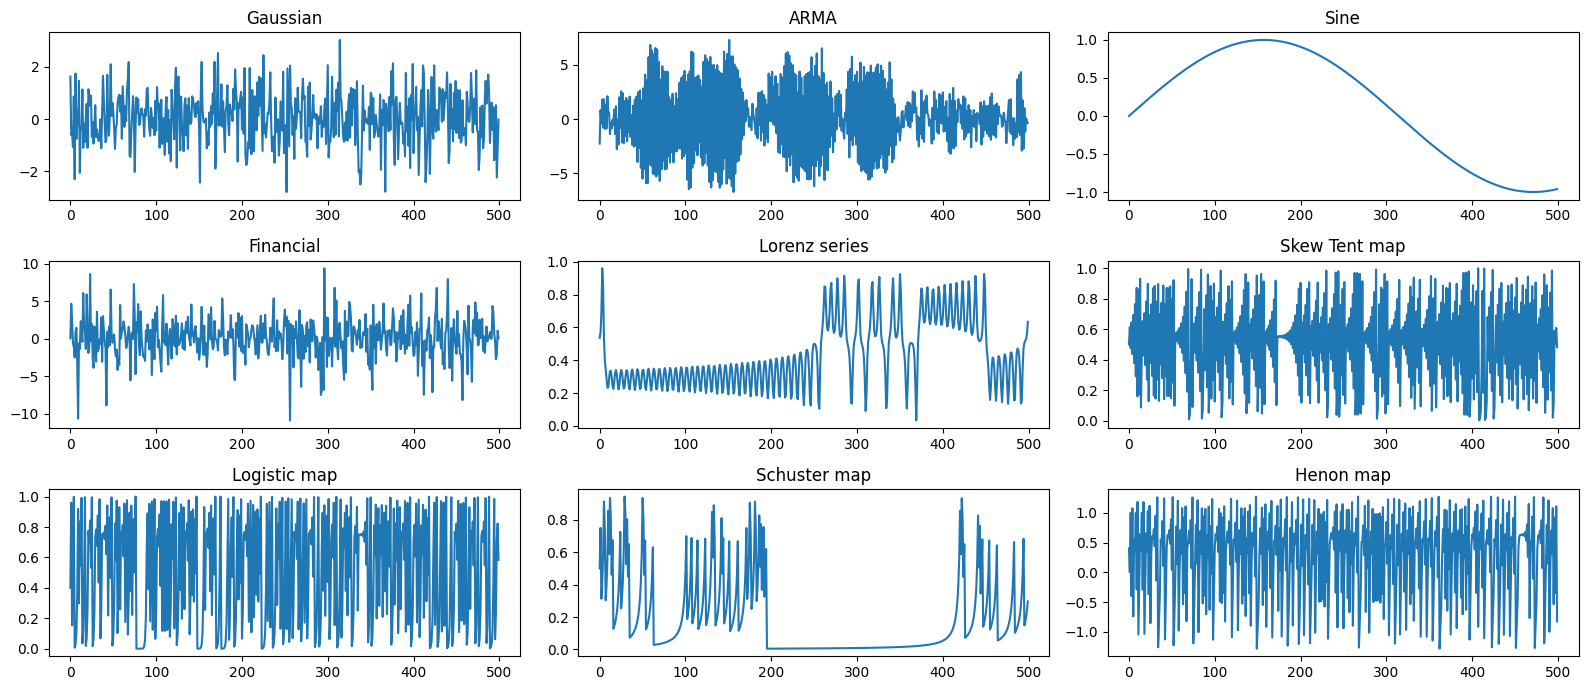

In [8]:
from more_itertools import flatten
fig, ax = plt.subplots(3, 3, figsize=(16, 7))
axs = list()
for axi, (k, v) in zip(flatten(ax), series.items()):
    axi.plot(v[:500])
    axi.set_title(k)
fig.tight_layout()

In [9]:
hc_max_curve = maximum_complexity_entropy(dx=6).T
hc_min_curve = minimum_complexity_entropy(dx=6).T

In [10]:
plot_values = np.array([complexity_entropy(x, dx=6, dy=1) for x in series.values()])

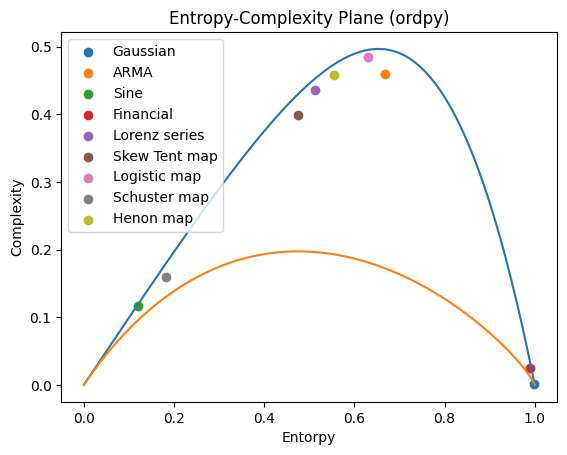

In [11]:
fig, ax = plt.subplots()
for name, x in zip(series.keys(), plot_values):
    ax.scatter(*x, label=name)

plt.legend()
plt.plot(*hc_max_curve)
plt.plot(*hc_min_curve)
plt.xlabel("Entorpy")
plt.ylabel("Complexity")
plt.title("Entropy-Complexity Plane (ordpy)")
plt.show()

# Custom implementation

In [12]:
def base_2_to_10_array(arr):
    res = 0
    for bit in arr:
        res = (res << 1) ^ bit
    return res

def ordinal_distribution_(data, dx=3, dy=1, taux=1, tauy=1, return_missing=True):
    binary_data = np.signbit(np.diff(data))#.astype(int)
    patterns = np.lib.stride_tricks.sliding_window_view(binary_data, (dx-1,))
    bits = np.apply_along_axis(base_2_to_10_array, axis=1, arr=patterns)
    values, counts = np.unique(bits, return_counts=True)
    counts_all = np.zeros(2**(dx-1))
    counts_all[values] = counts
    return values, counts_all / len(bits)

In [13]:
def entropy(p):
    p = p[p > 0]
    return - np.sum(p * np.log2(p))

def js_divergence(p, q):
    return entropy((p + q) / 2) - ((entropy(p) + entropy(q)) / 2)

def max_js_divergence(n):
    return -0.5*(((n+1)/n)*np.log2(n+1) + np.log2(n) - 2*np.log2(2*n))

def complexity_entropy_(data, dx=3, dy=1, taux=1, tauy=1):
    n = 2**(dx-1)
    q_uniform = np.repeat(1/n, n)

    _, p_ordinal = ordinal_distribution_(data, dx, dy, taux, tauy, return_missing=True)

    h = entropy(p_ordinal) / np.log2(n)
    js_div = js_divergence(p_ordinal, q_uniform)
    js_div_max = max_js_divergence(n)

    return h, h * js_div / js_div_max

In [14]:
def minimum_complexity_entropy(dx=3, dy=1, size=100):
    # n = math.factorial(dx*dy)
    n = 2**(dx-1)
    q_uniform = np.repeat(1/n, n)
    peak_prob = np.linspace(1/n, 1, num=size)

    entropy_array = np.empty(size)
    complexity_array = np.empty(size)
    for i in range(size):
        p_peak = np.full(shape=n, fill_value=(1-peak_prob[i])/(n-1))
        p_peak[0] = peak_prob[i]

        h = entropy(p_peak) / np.log2(n)
        js_div = js_divergence(p_peak, q_uniform)
        js_div_max = max_js_divergence(n)

        entropy_array[i] = h
        complexity_array[i] = h * js_div / js_div_max

    return entropy_array, complexity_array

In [15]:
def maximum_complexity_entropy(dx=3, dy=1, m=1):
    n = 2**(dx-1)
    entropy_array, complexity_array = np.zeros(shape=(n-1,m)), np.zeros(shape=(n-1,m))

    q_uniform = np.full(n, 1/n)
    prob_params = np.linspace(0, 1/n, num=m)

    for i in range(n-1):
        p = np.zeros(shape=n)
        for k in range(len(prob_params)):
            p[0] = prob_params[k]
            for j in range(1,n-i):
                p[j] = (1-prob_params[k])/(n-i-1)

            h = entropy(p) / np.log2(n)
            js_div = js_divergence(p, q_uniform)
            js_div_max = max_js_divergence(n)

            entropy_array[i, k] = h
            complexity_array[i, k] = h*js_div/js_div_max

    entropy_array = entropy_array.flatten()
    complexity_array = complexity_array.flatten()
    order = np.argsort(entropy_array)

    return entropy_array[order], complexity_array[order]

In [16]:
plot_values_ = np.array([complexity_entropy_(x, dx=6, dy=1) for x in series.values()])

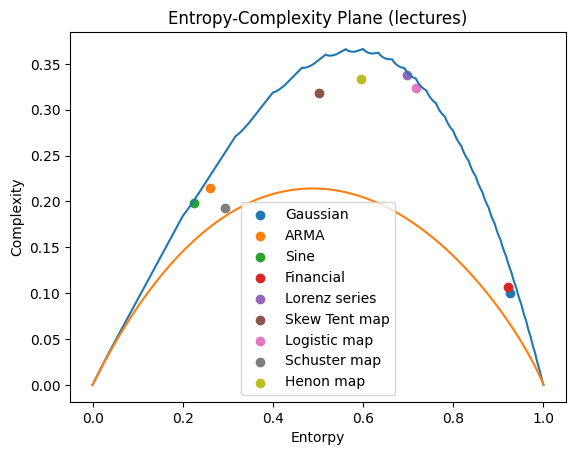

In [17]:
fig, ax = plt.subplots()
for name, x in zip(series.keys(), plot_values_):
    # h, e = complexity_entropy(x, dx=6, dy=1)
    ax.scatter(*x, label=name)

plt.legend()
plt.plot(*maximum_complexity_entropy(dx=6, m=1000))
plt.plot(*minimum_complexity_entropy(dx=6, size=100))
plt.xlabel("Entorpy")
plt.ylabel("Complexity")
plt.title("Entropy-Complexity Plane (lectures)")
plt.show()